In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import pandas as pd
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%config IPCompleter.use_jedi = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

> With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. It's still Bayesian classification, but it's no longer naive.

> The general approach for generative classification is this:  
>>1. Split the training data by label.  
>2. For each set, fit a KDE to obtain a generative model of the data. This allows you for any observation $x$ and label $y$ to compute a likelihood $P(x | y)$.  
>3. From the number of examples of each class in the training set, compute the class prior, $P(y)$.  
>4. For an unknown point x, the posterior probability for each class is $P(y | x)\propto P(x | y)P(y)$.   The class which maximizes this posterior is the label assigned to the point.  

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KernelDensity



class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passed to KernelDensity
    """
    def __init__(self, bandwidth: float = 1, kernel: str ='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        training_sets = [X[y==yi] for yi in self.classes_]
        
        # Calculate the KDEs per class
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                             kernel=self.kernel).fit(Xi) 
                               for Xi in training_sets]
        
        # Prior = fraction of class occurance
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        
        return self
        
    def predict_proba(self, X):
        
        # Retrieving the log-probs for every data point according to each model
        logprobs = [model.score_samples(X) for model in self.models_]
        
        # logprob -> prob
        probs = np.exp(np.array(logprobs).T + self.logpriors_)
        
        # Normalize such that sum(prob) = 1 for every data point
        return probs/probs.sum(axis=1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[self.predict_proba(X).argmax(axis=1)]

In [3]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

In [4]:
%%time
bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths}, n_jobs=-1)
grid.fit(digits.data, digits.target)

CPU times: user 3.59 s, sys: 365 ms, total: 3.96 s
Wall time: 6.56 s


GridSearchCV(estimator=KDEClassifier(), n_jobs=-1,
             param_grid={'bandwidth': array([  1.        ,   1.04761575,   1.09749877,   1.149757  ,
         1.20450354,   1.26185688,   1.32194115,   1.38488637,
         1.45082878,   1.51991108,   1.59228279,   1.66810054,
         1.7475284 ,   1.83073828,   1.91791026,   2.009233  ,
         2.10490414,   2.20513074,   2.3101297 ,   2.42012826,
         2.53536449,   2.65608778,   2.7825594 ,   2.91505306,
         3.05385551,   3.19926714...
        23.64489413,  24.77076356,  25.95024211,  27.18588243,
        28.48035868,  29.8364724 ,  31.2571585 ,  32.74549163,
        34.30469286,  35.93813664,  37.64935807,  39.44206059,
        41.320124  ,  43.28761281,  45.34878508,  47.50810162,
        49.77023564,  52.14008288,  54.62277218,  57.22367659,
        59.94842503,  62.80291442,  65.79332247,  68.92612104,
        72.20809018,  75.64633276,  79.24828984,  83.02175681,
        86.97490026,  91.11627561,  95.45484567, 100.  

In [5]:
scores = grid.cv_results_['mean_test_score']

{'bandwidth': 6.135907273413174}
accuracy = 0.9677298050139276


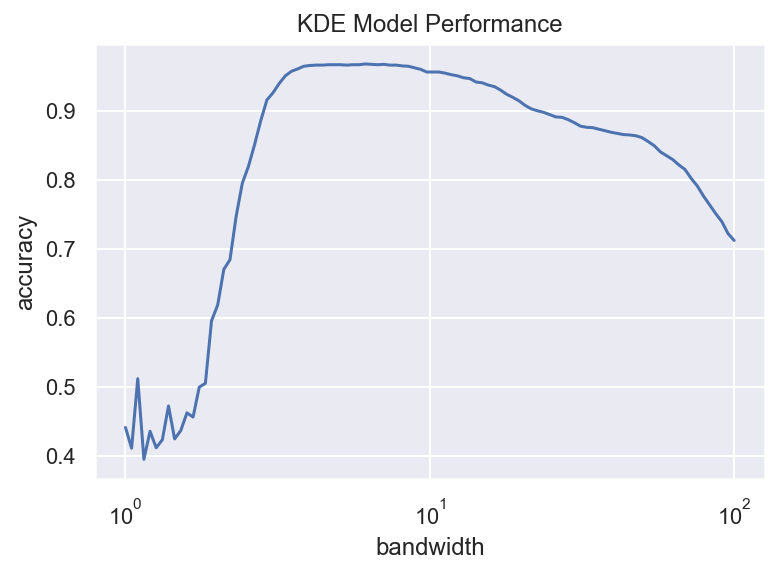

In [6]:
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

> We see that this not-so-naive Bayesian classifier reaches a cross-validation accuracy of just over 96%; this is compared to around 80% for the naive Bayesian classification:

In [7]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.8069281956050759

> If you would like to take this further, there are some improvements that could be made to our KDE classifier model:

* we could allow the bandwidth in each class to vary independently
* we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model within each class (i.e. use the scores from KernelDensity itself rather than the global prediction accuracy)